# 1. Imports

In [1]:
from data_preparation import *
from preprocessing import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    top_k_accuracy_score,
)

import torchmetrics
from torchmetrics.classification import MulticlassConfusionMatrix

# 1.1. SEED SET

In [2]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

# 2. Data

In [ ]:
path = ''

select_subject=1
fs=200
number_gestures=4
record_time=5
train_repetition=[1, 2, 3, 4, 5]
test_repetition=[6, 7, 8, 9, 10]

gesture=[1, 2, 3, 4]
selected_gesture=[1, 2, 3, 4]
num_gesture=len(gesture)

notch_freq=60.0 
low_cut=10.0
high_cut=99.0
order=5

window_time=200 
overlap=60
no_channel=8

batch_size = 32

In [4]:
emg_prep = EMGDataPreparation(base_path=path, fs=fs, rec_time=record_time)
subject_path, train_gesture, test_gesture = emg_prep.get_per_subject_file(subject_number=select_subject, num_gesture=num_gesture, train_repetition=train_repetition, test_repetition=test_repetition)
train_data, test_data = emg_prep.load_data_per_subject(subject_path, selected_gesture=selected_gesture, train_gesture=train_gesture, test_gesture=test_gesture)
train_data, train_labels = emg_prep.get_data_labels(train_data)
test_data, test_labels = emg_prep.get_data_labels(test_data)

## 2.1 Data Preprocessing

In [5]:
preprocess = EMGPreprocessing(fs=200, notch_freq=notch_freq, low_cut=low_cut, high_cut=high_cut, order=order)
train_data = preprocess.remove_mains(train_data)
test_data = preprocess.remove_mains(test_data)
train_data = preprocess.bandpass_filter(train_data)
test_data = preprocess.bandpass_filter(test_data)

In [6]:
# Overlap Windowing
window_train_data, window_train_labels = emg_prep.window_with_overlap(train_data, train_labels, window_time=200, overlap=60, no_channel=8)
window_test_data, window_test_labels = emg_prep.window_with_overlap(test_data, test_labels, window_time=200, overlap=60, no_channel=8)

# Expand Dimension
window_train_data = np.expand_dims(window_train_data, axis=1)
window_test_data = np.expand_dims(window_test_data, axis=1)

# # Normalize Data
# window_train_data = min_max_normalization(window_train_data)
# window_test_data = min_max_normalization(window_test_data)

# Shuffle Data
window_train_data, window_train_labels = shuffle_data(window_train_data, window_train_labels)
window_test_data, window_test_labels = shuffle_data(window_test_data, window_test_labels)

# Print
print(f'The max value of train data: {np.max(window_train_data)}')
print(f'The min value of train data: {np.min(window_train_data)}')
print(f'The max value of test data: {np.max(window_test_data)}')
print(f'The min value of test data: {np.min(window_test_data)}')

# Convert to Tensor
train_dataset = EMGDataset(window_train_data, window_train_labels)
test_dataset = EMGDataset(window_test_data, window_test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)


window_train_data.shape, window_train_labels.shape, window_test_data.shape, window_test_labels.shape

The max value of train data: 165.4396117225104
The min value of train data: -159.59747480488096
The max value of test data: 153.85377440815324
The min value of test data: -144.10678156701627


((1248, 1, 8, 40), (1248,), (1248, 1, 8, 40), (1248,))

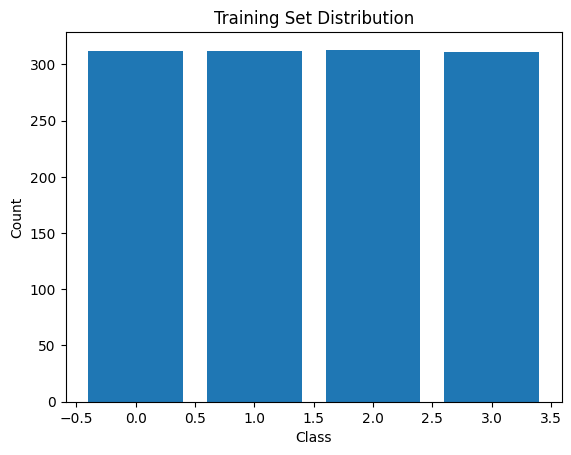

In [7]:
np.unique(window_train_labels, return_counts=True)
counts_train = np.unique(window_train_labels, return_counts=True)



plt.bar(counts_train[0], counts_train[1])
plt.title('Training Set Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# 3. EMGFAN Architecture

In [8]:
class FANLayer(nn.Module):

    
    def __init__(self, input_dim, output_dim, p_ratio=0.25, activation='gelu', use_p_bias=True):
        super(FANLayer, self).__init__()
        
        # Ensure the p_ratio is within a valid range
        assert 0 < p_ratio < 0.5, "p_ratio must be between 0 and 0.5"
        
        self.p_ratio = p_ratio
        p_output_dim = int(output_dim * self.p_ratio)
        g_output_dim = output_dim - p_output_dim * 2  # Account for cosine and sine terms

        # Linear transformation for the p component (for cosine and sine parts)
        self.input_linear_p = nn.Linear(input_dim, p_output_dim, bias=use_p_bias)
        
        # Linear transformation for the g component
        self.input_linear_g = nn.Linear(input_dim, g_output_dim)
        
        # Set the activation function
        if isinstance(activation, str):
            self.activation = getattr(F, activation)
        else:
            self.activation = activation if activation else lambda x: x

    def forward(self, src):
        """
        Args:
            src (Tensor): Input tensor of shape (batch_size, input_dim).
        
        Returns:
            Tensor: Output tensor of shape (batch_size, output_dim), after applying the FAN layer.
        """
        
        # Apply the linear transformation followed by the activation for the g component

        g = self.activation(self.input_linear_g(src))
        
        # Apply the linear transformation for the p component
        p = self.input_linear_p(src)

        # Concatenate cos(p), sin(p), and activated g along the last dimension
        output = torch.cat((torch.cos(p), torch.sin(p), g), dim=-1)

        
        return output

In [9]:
class EMGFAN(nn.Module):
    def __init__(self, input_dim=1, num_gesture=4, similarparameter=False):
        super(EMGFAN, self).__init__()
        self.similarparameter = similarparameter
        self.out_gesture = num_gesture
        self.in_channel = input_dim

        self.conv1 = nn.Conv2d(self.in_channel, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.scalar = lambda x: x*4//3 if self.similarparameter else x
        self.FAN = FANLayer(1152, self.scalar(256))
        self.fc2 = nn.Linear(256, self.out_gesture)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchnorm1(x) 
        x = self.maxpool2(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.FAN(x)
        x = self.fc2(x)
        return x

## 3.1. Load Pretrained Model

In [10]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EMGFAN(1, num_gesture=number_gestures, similarparameter=False).to(device)
save_dir = '/mnt/d/AI-Workspace/VLM/VLM-EMG4Gesture/CKAN-EMG-Decoder/model_weights/all/fan_33.pth'
model.load_state_dict(torch.load(save_dir))

<All keys matched successfully>

# 4. Fine-Tune

In [11]:
def test_loop(model, train_device, data, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in data:
            X = X.float().to(train_device)
            y = y.long().to(train_device)
            model = model.to(train_device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            test_loss += loss.item()
            total += y.size(0)
            correct += (y_pred.argmax(1) == y).sum().item()

    return test_loss / total, correct / total

## 4.1. None

In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
print(f"CLER for None")
test_loss, test_acc = test_loop(model, device, test_dataloader, criterion)
print(f'CLER {100 - test_acc*100:.4f}%')

CLER for None
CLER 35.0962%


## 4.2. Full-Train Fine-Tune

In [14]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
full_layer_model = EMGFAN(1, num_gesture=number_gestures, similarparameter=False).to(device)
save_dir = '/mnt/d/AI-Workspace/VLM/VLM-EMG4Gesture/CKAN-EMG-Decoder/model_weights/all/fan_33.pth'
full_layer_model.load_state_dict(torch.load(save_dir))

<All keys matched successfully>

In [15]:
epochs = 16
learning_rate = 0.001
optimizer = optim.Adam(full_layer_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [16]:
def fine_tune_loop(model, train_device, data, loss_fn, optimizer):

    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for X, y in data:


        optimizer.zero_grad()

        X = X.float().to(train_device)
        y = y.long().to(train_device)
        model = model.to(train_device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        #scheduler.step()

        train_loss += loss.item()
        total += y.size(0)
        correct += (y_pred.argmax(1) == y).sum().item()

    return train_loss / total, correct / total

In [17]:
print(f"FineTune on {device}")
train_accuracy_per_epoch = []

for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(full_layer_model, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)

AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')

FineTune on cuda


100%|██████████| 16/16 [00:01<00:00, 12.56it/s]

Epoch 16/16
The Average FineTune Accuracy: 91.6066%
The Last FineTune Accuracy 97.1154%


In [18]:
print(f"CLER for Full Layer FineTune")
test_loss, test_acc = test_loop(full_layer_model, device, test_dataloader, criterion)
print(f'CLER {100 - test_acc*100:.4f}%')

CLER for Full Layer FineTune
CLER 17.3077%


## 4.3. Last-Layer Fine-Tune

In [19]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
last_layer_model = EMGFAN(1, num_gesture=number_gestures, similarparameter=False).to(device)
save_dir = '/mnt/d/AI-Workspace/VLM/VLM-EMG4Gesture/CKAN-EMG-Decoder/model_weights/all/fan_33.pth'
last_layer_model.load_state_dict(torch.load(save_dir))

<All keys matched successfully>

In [20]:
for param in last_layer_model.parameters():
    param.requires_grad = False
for param in last_layer_model.fc2.parameters():
    param.requires_grad = True

def is_layer_frozen(layer):
    return all(not param.requires_grad for param in layer.parameters())
print("fc1 is frozen:", is_layer_frozen(last_layer_model.fc2))

fc1 is frozen: False


In [21]:
print(f"FineTune on {device}")
train_accuracy_per_epoch = []

for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = fine_tune_loop(last_layer_model, device, train_dataloader, criterion, optimizer)
    train_accuracy_per_epoch.append(train_acc)

AVG_TRAIN_ACC = np.mean(train_accuracy_per_epoch)
print(f"Epoch {epoch+1}/{epochs}")
print(f"The Average FineTune Accuracy: {AVG_TRAIN_ACC*100:.4f}%")
print(f'The Last FineTune Accuracy {train_acc*100:.4f}%')

FineTune on cuda


100%|██████████| 16/16 [00:00<00:00, 18.11it/s]

Epoch 16/16
The Average FineTune Accuracy: 51.8029%
The Last FineTune Accuracy 51.6026%


In [22]:
print(f"CLER for Last Layer FineTune")
test_loss, test_acc = test_loop(last_layer_model, device, test_dataloader, criterion)
print(f'Test accuracy {100 - test_acc*100:.4f}%')

CLER for Last Layer FineTune
Test accuracy 37.9006%
